In [1]:
import os
import math
import time
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, Module
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics import AUROC, Accuracy, MeanSquaredError
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from torch_frame import stype
from torch_frame.data import Dataset, DataLoader
from torch_frame.datasets import (
    ForestCoverType, KDDCensusIncome, DataFrameBenchmark,
    AdultCensusIncome, BankMarketing, Dota2
)
from torch_frame.gbdt import CatBoost, LightGBM, XGBoost
from torch_frame.nn import (
    EmbeddingEncoder, FTTransformer, LinearBucketEncoder,
    LinearEncoder, LinearPeriodicEncoder, ResNet, TabNet, TabTransformer
)
from torch_frame.nn.models import (
    MLP, ExcelFormer, Trompt
)
from torch_frame.typing import TaskType



# Use GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\cleo7\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ML

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import catboost as cb
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [3]:
df = pd.read_csv("heart_disease.csv")

In [4]:
# Heart Disease를 종속 변수(y)로 설정
y_col = "target"
y = df[y_col]

# 독립 변수(X) 설정 (Patient_ID 제거)
X = df.drop(columns=[y_col])

# 연속형 변수 (float, int)와 범주형 변수 분리
continuous_vars = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_vars = X.select_dtypes(include=["object"]).columns.tolist()

In [5]:
df_encoded = pd.get_dummies(df, columns=categorical_vars)
X = df_encoded.drop(columns=y_col)

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model

### Logistic Regression

In [7]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
log_acc = accuracy_score(y_test, y_pred_log)
print(f'Logistic Regression Accuracy: {log_acc:.4f}')

Logistic Regression Accuracy: 0.8852


c:\Users\cleo7\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [8]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_acc:.4f}')

Random Forest Accuracy: 0.8361


### Decision Tree

In [9]:
dt_params = {'max_depth': [3, 5, 10, 15, None]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_

y_pred_dt = dt_best.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print("🔹 Decision Tree Results:")
print("Best Parameters:", dt_grid.best_params_)
print("Accuracy:", acc_dt)
print(classification_report(y_test, y_pred_dt))

🔹 Decision Tree Results:
Best Parameters: {'max_depth': 3}
Accuracy: 0.819672131147541
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        29
           1       0.84      0.81      0.83        32

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



### XGBoost

In [10]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("🔹 XGBoost Classifier Results:")
print("Accuracy:", acc_xgb)
print(classification_report(y_test, y_pred_xgb))

🔹 XGBoost Classifier Results:
Accuracy: 0.8360655737704918
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        29
           1       0.87      0.81      0.84        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



c:\Users\cleo7\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### LightGBM

In [11]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, 
                                 n_estimators=200, force_col_wise=True, random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

acc_lgb = accuracy_score(y_test, y_pred_lgb)

print("🔹 LightGBM Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Info] Number of positive: 133, number of negative: 109
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.549587 -> initscore=0.199001
[LightGBM] [Info] Start training from score 0.199001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

### CatBoost

In [12]:
cat_model = cb.CatBoostClassifier(iterations=200, depth=6, learning_rate=0.05, loss_function='Logloss', verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)

print("🔹 CatBoost Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

🔹 CatBoost Model Performance 🔹
Accuracy: 0.819672131147541
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        29
           1       0.84      0.81      0.83        32

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



# DL

In [13]:
df = pd.read_csv("heart_disease.csv")

In [14]:
# 분류 task
is_classification = True

In [15]:
from torch_frame import numerical, categorical, text_embedded, embedding

## 칼럼 별 Dtype 지정 
col_to_stype={"age" : numerical,
              "sex" : categorical,
              "cp" : numerical,
              "trestbps" : numerical,
              "chol" : numerical,
              "fbs" : categorical,
              "restecg" : numerical,
              "thalach" : numerical,
              "exang" : categorical,
              "oldpeak" : numerical,
              "slope" : categorical,
              "ca" : numerical,
              "thal" : numerical,
              "target" : categorical}

dataset = Dataset(df=df, 
                  col_to_stype=col_to_stype, 
                  target_col='target')

dataset.materialize()

## split
train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]

### ResNet

In [16]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [17]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'resnet',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [18]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count

@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [19]:
from sklearn.model_selection import KFold

# K-Fold 설정
k_folds = args.k_folds if hasattr(args, 'k_folds') else 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=args.seed if hasattr(args, 'seed') else None)

dataset_indices = list(range(len(dataset)))
best_val_metric = 0 if is_classification else float('inf')
best_test_metric = 0 if is_classification else float('inf')

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 데이터 분할
    train_dataset = dataset[train_idx]
    val_dataset = dataset[val_idx]
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)

    if args.numerical_encoder_type == 'linear':
        numerical_encoder = LinearEncoder()
    elif args.numerical_encoder_type == 'linearbucket':
        numerical_encoder = LinearBucketEncoder()
    elif args.numerical_encoder_type == 'linearperiodic':
        numerical_encoder = LinearPeriodicEncoder()
    else:
        raise ValueError(
            f'Unsupported encoder type: {args.numerical_encoder_type}')

    stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}
    
    # 모델 초기화
    if args.model_type == 'fttransformer':
        model = FTTransformer(
            channels=args.channels,
            out_channels = 2,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
            stype_encoder_dict=stype_encoder_dict,
        ).to(device)
    elif args.model_type == 'resnet':
        model = ResNet(
            channels=args.channels,
            out_channels = 2,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
        ).to(device)
    else:
        raise ValueError(f'Unsupported model type: {args.model_type}')
    
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    
    metric = 'Acc'
    
    # 훈련
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        
        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        
        print(f'Fold {fold + 1}, Epoch {epoch}: Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}')

print(f'Final Best Val {metric}: {best_val_metric:.4f}, Final Best Test {metric}: {best_test_metric:.4f}')


Fold 1/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


Fold 1, Epoch 1: Train Loss: 0.7187, Train Acc: 0.7645, Val Acc: 0.8197


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 23.85it/s]


Fold 1, Epoch 2: Train Loss: 0.6109, Train Acc: 0.7769, Val Acc: 0.8033


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 17.97it/s]


Fold 1, Epoch 3: Train Loss: 0.5504, Train Acc: 0.7769, Val Acc: 0.8033


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 19.56it/s]


Fold 1, Epoch 4: Train Loss: 0.5401, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 26.01it/s]


Fold 1, Epoch 5: Train Loss: 0.4963, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s]


Fold 1, Epoch 6: Train Loss: 0.4966, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


Fold 1, Epoch 7: Train Loss: 0.5023, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


Fold 1, Epoch 8: Train Loss: 0.5234, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Fold 1, Epoch 9: Train Loss: 0.5131, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 23.80it/s]


Fold 1, Epoch 10: Train Loss: 0.5116, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 23.36it/s]

Fold 1, Epoch 11: Train Loss: 0.5013, Train Acc: 0.7810, Val Acc: 0.8033

Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 20.38it/s]


Fold 1, Epoch 12: Train Loss: 0.5089, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 26.86it/s]


Fold 1, Epoch 13: Train Loss: 0.4811, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 24.13it/s]


Fold 1, Epoch 14: Train Loss: 0.4932, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 19.81it/s]


Fold 1, Epoch 15: Train Loss: 0.4868, Train Acc: 0.7810, Val Acc: 0.8033
Fold 2/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


Fold 2, Epoch 1: Train Loss: 0.7087, Train Acc: 0.8017, Val Acc: 0.6557


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


Fold 2, Epoch 2: Train Loss: 0.5853, Train Acc: 0.7975, Val Acc: 0.6557


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


Fold 2, Epoch 3: Train Loss: 0.5205, Train Acc: 0.7975, Val Acc: 0.6393


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 16.99it/s]


Fold 2, Epoch 4: Train Loss: 0.5087, Train Acc: 0.7975, Val Acc: 0.6393


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 26.15it/s]


Fold 2, Epoch 5: Train Loss: 0.4485, Train Acc: 0.8058, Val Acc: 0.6393


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 21.17it/s]


Fold 2, Epoch 6: Train Loss: 0.4516, Train Acc: 0.7975, Val Acc: 0.6721


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


Fold 2, Epoch 7: Train Loss: 0.4665, Train Acc: 0.7975, Val Acc: 0.6393


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 22.07it/s]


Fold 2, Epoch 8: Train Loss: 0.4519, Train Acc: 0.7975, Val Acc: 0.6393


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]


Fold 2, Epoch 9: Train Loss: 0.4862, Train Acc: 0.7975, Val Acc: 0.6393


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 17.86it/s]


Fold 2, Epoch 10: Train Loss: 0.4654, Train Acc: 0.7975, Val Acc: 0.6393


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 21.57it/s]


Fold 2, Epoch 11: Train Loss: 0.4530, Train Acc: 0.7975, Val Acc: 0.6393


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 22.70it/s]


Fold 2, Epoch 12: Train Loss: 0.4421, Train Acc: 0.7975, Val Acc: 0.6393


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 21.98it/s]

Fold 2, Epoch 13: Train Loss: 0.4515, Train Acc: 0.8017, Val Acc: 0.6393

Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 23.25it/s]


Fold 2, Epoch 14: Train Loss: 0.4441, Train Acc: 0.8099, Val Acc: 0.6393


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 22.29it/s]


Fold 2, Epoch 15: Train Loss: 0.4471, Train Acc: 0.8099, Val Acc: 0.6393
Fold 3/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 33.25it/s]


Fold 3, Epoch 1: Train Loss: 0.7394, Train Acc: 0.6777, Val Acc: 0.7377


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 29.90it/s]


Fold 3, Epoch 2: Train Loss: 0.6307, Train Acc: 0.7190, Val Acc: 0.8197


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 22.02it/s]


Fold 3, Epoch 3: Train Loss: 0.5733, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]

Fold 3, Epoch 4: Train Loss: 0.5511, Train Acc: 0.7851, Val Acc: 0.7705



Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 25.97it/s]


Fold 3, Epoch 5: Train Loss: 0.5336, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 21.04it/s]


Fold 3, Epoch 6: Train Loss: 0.5250, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 19.38it/s]

Fold 3, Epoch 7: Train Loss: 0.5023, Train Acc: 0.7851, Val Acc: 0.7705

Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


Fold 3, Epoch 8: Train Loss: 0.5148, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 24.65it/s]


Fold 3, Epoch 9: Train Loss: 0.5121, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 30.47it/s]

Fold 3, Epoch 10: Train Loss: 0.4890, Train Acc: 0.7851, Val Acc: 0.7705



Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 29.36it/s]


Fold 3, Epoch 11: Train Loss: 0.5085, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 25.47it/s]


Fold 3, Epoch 12: Train Loss: 0.4963, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


Fold 3, Epoch 13: Train Loss: 0.4830, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]


Fold 3, Epoch 14: Train Loss: 0.5033, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 17.36it/s]


Fold 3, Epoch 15: Train Loss: 0.4976, Train Acc: 0.7893, Val Acc: 0.7705
Fold 4/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


Fold 4, Epoch 1: Train Loss: 0.7305, Train Acc: 0.7284, Val Acc: 0.8333


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 20.89it/s]

Fold 4, Epoch 2: Train Loss: 0.6096, Train Acc: 0.7654, Val Acc: 0.8167

Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


Fold 4, Epoch 3: Train Loss: 0.5694, Train Acc: 0.7613, Val Acc: 0.8333


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 20.44it/s]


Fold 4, Epoch 4: Train Loss: 0.5479, Train Acc: 0.7613, Val Acc: 0.8333


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 17.81it/s]


Fold 4, Epoch 5: Train Loss: 0.5253, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 23.03it/s]


Fold 4, Epoch 6: Train Loss: 0.5242, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


Fold 4, Epoch 7: Train Loss: 0.5095, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 23.58it/s]


Fold 4, Epoch 8: Train Loss: 0.5122, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 22.04it/s]


Fold 4, Epoch 9: Train Loss: 0.4990, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 18.77it/s]


Fold 4, Epoch 10: Train Loss: 0.4894, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 19.92it/s]


Fold 4, Epoch 11: Train Loss: 0.5167, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 20.41it/s]


Fold 4, Epoch 12: Train Loss: 0.5116, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 22.01it/s]


Fold 4, Epoch 13: Train Loss: 0.4979, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]


Fold 4, Epoch 14: Train Loss: 0.4879, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


Fold 4, Epoch 15: Train Loss: 0.4925, Train Acc: 0.7737, Val Acc: 0.8333
Fold 5/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00, 22.95it/s]


Fold 5, Epoch 1: Train Loss: 0.7099, Train Acc: 0.7325, Val Acc: 0.6833


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


Fold 5, Epoch 2: Train Loss: 0.6227, Train Acc: 0.7366, Val Acc: 0.7333


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00, 20.94it/s]


Fold 5, Epoch 3: Train Loss: 0.5842, Train Acc: 0.7695, Val Acc: 0.7500


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s]


Fold 5, Epoch 4: Train Loss: 0.5312, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


Fold 5, Epoch 5: Train Loss: 0.5005, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00, 20.71it/s]


Fold 5, Epoch 6: Train Loss: 0.4934, Train Acc: 0.7695, Val Acc: 0.8167


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00, 15.44it/s]


Fold 5, Epoch 7: Train Loss: 0.5147, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00, 30.19it/s]


Fold 5, Epoch 8: Train Loss: 0.4969, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00, 21.55it/s]

Fold 5, Epoch 9: Train Loss: 0.5229, Train Acc: 0.7695, Val Acc: 0.8167



Epoch: 10: 100%|██████████| 1/1 [00:00<00:00, 20.84it/s]

Fold 5, Epoch 10: Train Loss: 0.4861, Train Acc: 0.7737, Val Acc: 0.8167



Epoch: 11: 100%|██████████| 1/1 [00:00<00:00, 24.14it/s]


Fold 5, Epoch 11: Train Loss: 0.4859, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00, 22.37it/s]


Fold 5, Epoch 12: Train Loss: 0.4673, Train Acc: 0.7901, Val Acc: 0.8167


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00, 24.68it/s]


Fold 5, Epoch 13: Train Loss: 0.4716, Train Acc: 0.7942, Val Acc: 0.8333


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00, 16.81it/s]


Fold 5, Epoch 14: Train Loss: 0.4692, Train Acc: 0.7942, Val Acc: 0.8333


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00, 21.52it/s]

Fold 5, Epoch 15: Train Loss: 0.4664, Train Acc: 0.7901, Val Acc: 0.8333
Final Best Val Acc: 0.8333, Final Best Test Acc: 0.8333


In [20]:
resnet_score = best_test_metric
resnet_score

0.8333333333333334

### FT-T

In [21]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [22]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'fttransformer',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [23]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count

@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [24]:
from sklearn.model_selection import KFold

# K-Fold 설정
k_folds = args.k_folds if hasattr(args, 'k_folds') else 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=args.seed if hasattr(args, 'seed') else None)

dataset_indices = list(range(len(dataset)))
best_val_metric = 0 if is_classification else float('inf')
best_test_metric = 0 if is_classification else float('inf')

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 데이터 분할
    train_dataset = dataset[train_idx]
    val_dataset = dataset[val_idx]
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)

    if args.numerical_encoder_type == 'linear':
        numerical_encoder = LinearEncoder()
    elif args.numerical_encoder_type == 'linearbucket':
        numerical_encoder = LinearBucketEncoder()
    elif args.numerical_encoder_type == 'linearperiodic':
        numerical_encoder = LinearPeriodicEncoder()
    else:
        raise ValueError(
            f'Unsupported encoder type: {args.numerical_encoder_type}')

    stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}
    
    # 모델 초기화
    if args.model_type == 'fttransformer':
        model = FTTransformer(
            channels=args.channels,
            out_channels = 2,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
            stype_encoder_dict=stype_encoder_dict,
        ).to(device)
    elif args.model_type == 'resnet':
        model = ResNet(
            channels=args.channels,
            out_channels = 2,
            num_layers=args.num_layers,
            col_stats=dataset.col_stats,
            col_names_dict=train_tensor_frame.col_names_dict,
        ).to(device)
    else:
        raise ValueError(f'Unsupported model type: {args.model_type}')
    
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)
    
    metric = 'Acc'
    
    # 훈련
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        
        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        
        print(f'Fold {fold + 1}, Epoch {epoch}: Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}')

print(f'Final Best Val {metric}: {best_val_metric:.4f}, Final Best Test {metric}: {best_test_metric:.4f}')


Fold 1/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Fold 1, Epoch 1: Train Loss: 0.7724, Train Acc: 0.5785, Val Acc: 0.5082


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Fold 1, Epoch 2: Train Loss: 0.6818, Train Acc: 0.5744, Val Acc: 0.5738


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Fold 1, Epoch 3: Train Loss: 0.6457, Train Acc: 0.6736, Val Acc: 0.6885


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Fold 1, Epoch 4: Train Loss: 0.6305, Train Acc: 0.7025, Val Acc: 0.7049


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Fold 1, Epoch 5: Train Loss: 0.6136, Train Acc: 0.7273, Val Acc: 0.7377


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Fold 1, Epoch 6: Train Loss: 0.5753, Train Acc: 0.7603, Val Acc: 0.8033


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Fold 1, Epoch 7: Train Loss: 0.5585, Train Acc: 0.7603, Val Acc: 0.8033


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Fold 1, Epoch 8: Train Loss: 0.5516, Train Acc: 0.7603, Val Acc: 0.7869


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Fold 1, Epoch 9: Train Loss: 0.5368, Train Acc: 0.7603, Val Acc: 0.7869


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


Fold 1, Epoch 10: Train Loss: 0.5206, Train Acc: 0.7603, Val Acc: 0.7869


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Fold 1, Epoch 11: Train Loss: 0.5294, Train Acc: 0.7603, Val Acc: 0.7869


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Fold 1, Epoch 12: Train Loss: 0.5208, Train Acc: 0.7727, Val Acc: 0.8033


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Fold 1, Epoch 13: Train Loss: 0.5156, Train Acc: 0.7769, Val Acc: 0.8033


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Fold 1, Epoch 14: Train Loss: 0.5103, Train Acc: 0.7810, Val Acc: 0.8033


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Fold 1, Epoch 15: Train Loss: 0.5008, Train Acc: 0.7810, Val Acc: 0.8033
Fold 2/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Fold 2, Epoch 1: Train Loss: 0.7317, Train Acc: 0.5620, Val Acc: 0.4754


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


Fold 2, Epoch 2: Train Loss: 0.6672, Train Acc: 0.5744, Val Acc: 0.4918


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Fold 2, Epoch 3: Train Loss: 0.6312, Train Acc: 0.6860, Val Acc: 0.5574


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Fold 2, Epoch 4: Train Loss: 0.6175, Train Acc: 0.7521, Val Acc: 0.5902


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Fold 2, Epoch 5: Train Loss: 0.5745, Train Acc: 0.8017, Val Acc: 0.6885


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Fold 2, Epoch 6: Train Loss: 0.5361, Train Acc: 0.8099, Val Acc: 0.6885


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Fold 2, Epoch 7: Train Loss: 0.5277, Train Acc: 0.8058, Val Acc: 0.6885


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Fold 2, Epoch 8: Train Loss: 0.5219, Train Acc: 0.8058, Val Acc: 0.6885


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Fold 2, Epoch 9: Train Loss: 0.4987, Train Acc: 0.8058, Val Acc: 0.6885


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Fold 2, Epoch 10: Train Loss: 0.4676, Train Acc: 0.8099, Val Acc: 0.6885


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Fold 2, Epoch 11: Train Loss: 0.5011, Train Acc: 0.8099, Val Acc: 0.6885


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Fold 2, Epoch 12: Train Loss: 0.4769, Train Acc: 0.8099, Val Acc: 0.6885


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Fold 2, Epoch 13: Train Loss: 0.4746, Train Acc: 0.8099, Val Acc: 0.6885


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Fold 2, Epoch 14: Train Loss: 0.4711, Train Acc: 0.8099, Val Acc: 0.6885


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Fold 2, Epoch 15: Train Loss: 0.4794, Train Acc: 0.8099, Val Acc: 0.6885
Fold 3/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Fold 3, Epoch 1: Train Loss: 0.6901, Train Acc: 0.7314, Val Acc: 0.7869


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Fold 3, Epoch 2: Train Loss: 0.6506, Train Acc: 0.7355, Val Acc: 0.8033


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Fold 3, Epoch 3: Train Loss: 0.6308, Train Acc: 0.7810, Val Acc: 0.7705


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


Fold 3, Epoch 4: Train Loss: 0.5823, Train Acc: 0.7810, Val Acc: 0.7705


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Fold 3, Epoch 5: Train Loss: 0.5582, Train Acc: 0.7810, Val Acc: 0.7705


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Fold 3, Epoch 6: Train Loss: 0.5369, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Fold 3, Epoch 7: Train Loss: 0.5311, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Fold 3, Epoch 8: Train Loss: 0.5408, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Fold 3, Epoch 9: Train Loss: 0.5289, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Fold 3, Epoch 10: Train Loss: 0.5177, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Fold 3, Epoch 11: Train Loss: 0.5409, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Fold 3, Epoch 12: Train Loss: 0.5326, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Fold 3, Epoch 13: Train Loss: 0.5057, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Fold 3, Epoch 14: Train Loss: 0.5269, Train Acc: 0.7851, Val Acc: 0.7705


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Fold 3, Epoch 15: Train Loss: 0.5227, Train Acc: 0.7851, Val Acc: 0.7705
Fold 4/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Fold 4, Epoch 1: Train Loss: 0.7189, Train Acc: 0.6831, Val Acc: 0.7333


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


Fold 4, Epoch 2: Train Loss: 0.6693, Train Acc: 0.7366, Val Acc: 0.7667


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fold 4, Epoch 3: Train Loss: 0.6111, Train Acc: 0.7325, Val Acc: 0.7333


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fold 4, Epoch 4: Train Loss: 0.5794, Train Acc: 0.7737, Val Acc: 0.7500


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fold 4, Epoch 5: Train Loss: 0.5706, Train Acc: 0.7695, Val Acc: 0.8167


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fold 4, Epoch 6: Train Loss: 0.5614, Train Acc: 0.7695, Val Acc: 0.8167


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Fold 4, Epoch 7: Train Loss: 0.5456, Train Acc: 0.7695, Val Acc: 0.8167


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


Fold 4, Epoch 8: Train Loss: 0.5372, Train Acc: 0.7695, Val Acc: 0.8167


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fold 4, Epoch 9: Train Loss: 0.5314, Train Acc: 0.7695, Val Acc: 0.8167


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Fold 4, Epoch 10: Train Loss: 0.4942, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fold 4, Epoch 11: Train Loss: 0.5359, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Fold 4, Epoch 12: Train Loss: 0.5099, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fold 4, Epoch 13: Train Loss: 0.5282, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fold 4, Epoch 14: Train Loss: 0.5283, Train Acc: 0.7695, Val Acc: 0.8333


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


Fold 4, Epoch 15: Train Loss: 0.5413, Train Acc: 0.7695, Val Acc: 0.8333
Fold 5/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fold 5, Epoch 1: Train Loss: 0.7378, Train Acc: 0.6955, Val Acc: 0.6667


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Fold 5, Epoch 2: Train Loss: 0.6542, Train Acc: 0.6996, Val Acc: 0.6500


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fold 5, Epoch 3: Train Loss: 0.6319, Train Acc: 0.7243, Val Acc: 0.6667


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


Fold 5, Epoch 4: Train Loss: 0.5848, Train Acc: 0.7325, Val Acc: 0.6833


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Fold 5, Epoch 5: Train Loss: 0.5986, Train Acc: 0.7449, Val Acc: 0.6833


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Fold 5, Epoch 6: Train Loss: 0.5614, Train Acc: 0.7613, Val Acc: 0.7667


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Fold 5, Epoch 7: Train Loss: 0.5276, Train Acc: 0.7695, Val Acc: 0.8167


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Fold 5, Epoch 8: Train Loss: 0.5369, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fold 5, Epoch 9: Train Loss: 0.5089, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Fold 5, Epoch 10: Train Loss: 0.5324, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fold 5, Epoch 11: Train Loss: 0.5139, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Fold 5, Epoch 12: Train Loss: 0.5367, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Fold 5, Epoch 13: Train Loss: 0.5174, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Fold 5, Epoch 14: Train Loss: 0.5142, Train Acc: 0.7737, Val Acc: 0.8167


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


Fold 5, Epoch 15: Train Loss: 0.5043, Train Acc: 0.7778, Val Acc: 0.8167
Final Best Val Acc: 0.8333, Final Best Test Acc: 0.8333


In [25]:
ftt_score = best_test_metric
ftt_score

0.8333333333333334

### TabNet

In [26]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="ForestCoverType",
                    choices=["ForestCoverType", "KDDCensusIncome"])
parser.add_argument('--channels', type=int, default=128)
parser.add_argument('--gamma', type=int, default=1.2)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--batch_size', type=int, default=4096)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')


args = parser.parse_args([
    "--channels", "256",
    "--num_layers", "4",
    "--batch_size", "256",
    "--lr", "0.0001",
    "--epochs", "15"
])

torch.manual_seed(args.seed)

In [27]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count

@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [28]:
from sklearn.model_selection import KFold

# K-Fold 설정
k_folds = args.k_folds if hasattr(args, 'k_folds') else 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=args.seed if hasattr(args, 'seed') else None)

dataset_indices = list(range(len(dataset)))
best_val_metric = 0 if is_classification else float('inf')
best_test_metric = 0 if is_classification else float('inf')

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 데이터 분할
    train_dataset = dataset[train_idx]
    val_dataset = dataset[val_idx]
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)


    # 모델 초기화
    model = TabNet(
    out_channels = 2,
    num_layers=args.num_layers,
    split_attn_channels=args.channels,
    split_feat_channels=args.channels,
    gamma=args.gamma,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
    
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

    
    metric = 'Acc'
    
    # 훈련
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        
        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        
        print(f'Fold {fold + 1}, Epoch {epoch}: Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}')

print(f'Final Best Val {metric}: {best_val_metric:.4f}, Final Best Test {metric}: {best_test_metric:.4f}')


Fold 1/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Fold 1, Epoch 1: Train Loss: 0.6966, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Fold 1, Epoch 2: Train Loss: 0.6942, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Fold 1, Epoch 3: Train Loss: 0.6919, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Fold 1, Epoch 4: Train Loss: 0.6896, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Fold 1, Epoch 5: Train Loss: 0.6873, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Fold 1, Epoch 6: Train Loss: 0.6849, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Fold 1, Epoch 7: Train Loss: 0.6822, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Fold 1, Epoch 8: Train Loss: 0.6793, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


Fold 1, Epoch 9: Train Loss: 0.6762, Train Acc: 0.4587, Val Acc: 0.4426


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Fold 1, Epoch 10: Train Loss: 0.6728, Train Acc: 0.4628, Val Acc: 0.4590


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


Fold 1, Epoch 11: Train Loss: 0.6689, Train Acc: 0.4711, Val Acc: 0.4590


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


Fold 1, Epoch 12: Train Loss: 0.6650, Train Acc: 0.4876, Val Acc: 0.4590


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Fold 1, Epoch 13: Train Loss: 0.6611, Train Acc: 0.5041, Val Acc: 0.4754


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Fold 1, Epoch 14: Train Loss: 0.6571, Train Acc: 0.5455, Val Acc: 0.4918


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Fold 1, Epoch 15: Train Loss: 0.6527, Train Acc: 0.5785, Val Acc: 0.4918
Fold 2/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Fold 2, Epoch 1: Train Loss: 0.6961, Train Acc: 0.4380, Val Acc: 0.5246


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Fold 2, Epoch 2: Train Loss: 0.6931, Train Acc: 0.4380, Val Acc: 0.5246


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


Fold 2, Epoch 3: Train Loss: 0.6902, Train Acc: 0.4380, Val Acc: 0.5246


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Fold 2, Epoch 4: Train Loss: 0.6873, Train Acc: 0.4380, Val Acc: 0.5246


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Fold 2, Epoch 5: Train Loss: 0.6844, Train Acc: 0.4421, Val Acc: 0.5246


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Fold 2, Epoch 6: Train Loss: 0.6814, Train Acc: 0.4504, Val Acc: 0.5246


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


Fold 2, Epoch 7: Train Loss: 0.6782, Train Acc: 0.4793, Val Acc: 0.5410


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Fold 2, Epoch 8: Train Loss: 0.6749, Train Acc: 0.5124, Val Acc: 0.5738


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Fold 2, Epoch 9: Train Loss: 0.6713, Train Acc: 0.5455, Val Acc: 0.6066


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


Fold 2, Epoch 10: Train Loss: 0.6676, Train Acc: 0.5744, Val Acc: 0.6393


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Fold 2, Epoch 11: Train Loss: 0.6638, Train Acc: 0.6157, Val Acc: 0.6557


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Fold 2, Epoch 12: Train Loss: 0.6599, Train Acc: 0.6446, Val Acc: 0.6721


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


Fold 2, Epoch 13: Train Loss: 0.6558, Train Acc: 0.6653, Val Acc: 0.6885


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Fold 2, Epoch 14: Train Loss: 0.6514, Train Acc: 0.6818, Val Acc: 0.6721


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Fold 2, Epoch 15: Train Loss: 0.6469, Train Acc: 0.6942, Val Acc: 0.6721
Fold 3/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


Fold 3, Epoch 1: Train Loss: 0.6906, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Fold 3, Epoch 2: Train Loss: 0.6881, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Fold 3, Epoch 3: Train Loss: 0.6857, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Fold 3, Epoch 4: Train Loss: 0.6833, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


Fold 3, Epoch 5: Train Loss: 0.6807, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Fold 3, Epoch 6: Train Loss: 0.6780, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Fold 3, Epoch 7: Train Loss: 0.6752, Train Acc: 0.5331, Val Acc: 0.5902


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Fold 3, Epoch 8: Train Loss: 0.6722, Train Acc: 0.5372, Val Acc: 0.5902


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


Fold 3, Epoch 9: Train Loss: 0.6693, Train Acc: 0.5455, Val Acc: 0.6066


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Fold 3, Epoch 10: Train Loss: 0.6664, Train Acc: 0.5579, Val Acc: 0.6066


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Fold 3, Epoch 11: Train Loss: 0.6633, Train Acc: 0.5744, Val Acc: 0.6230


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


Fold 3, Epoch 12: Train Loss: 0.6600, Train Acc: 0.5950, Val Acc: 0.6885


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Fold 3, Epoch 13: Train Loss: 0.6564, Train Acc: 0.6116, Val Acc: 0.6885


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


Fold 3, Epoch 14: Train Loss: 0.6527, Train Acc: 0.6281, Val Acc: 0.7213


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Fold 3, Epoch 15: Train Loss: 0.6488, Train Acc: 0.6488, Val Acc: 0.7213
Fold 4/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


Fold 4, Epoch 1: Train Loss: 0.6980, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Fold 4, Epoch 2: Train Loss: 0.6950, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Fold 4, Epoch 3: Train Loss: 0.6922, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Fold 4, Epoch 4: Train Loss: 0.6896, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Fold 4, Epoch 5: Train Loss: 0.6868, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Fold 4, Epoch 6: Train Loss: 0.6840, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


Fold 4, Epoch 7: Train Loss: 0.6811, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


Fold 4, Epoch 8: Train Loss: 0.6783, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Fold 4, Epoch 9: Train Loss: 0.6748, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Fold 4, Epoch 10: Train Loss: 0.6713, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Fold 4, Epoch 11: Train Loss: 0.6676, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Fold 4, Epoch 12: Train Loss: 0.6637, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Fold 4, Epoch 13: Train Loss: 0.6598, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Fold 4, Epoch 14: Train Loss: 0.6555, Train Acc: 0.4691, Val Acc: 0.4000


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Fold 4, Epoch 15: Train Loss: 0.6509, Train Acc: 0.4815, Val Acc: 0.4000
Fold 5/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Fold 5, Epoch 1: Train Loss: 0.6925, Train Acc: 0.6831, Val Acc: 0.5833


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Fold 5, Epoch 2: Train Loss: 0.6897, Train Acc: 0.7202, Val Acc: 0.6000


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Fold 5, Epoch 3: Train Loss: 0.6872, Train Acc: 0.7572, Val Acc: 0.7167


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Fold 5, Epoch 4: Train Loss: 0.6845, Train Acc: 0.8025, Val Acc: 0.7500


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Fold 5, Epoch 5: Train Loss: 0.6816, Train Acc: 0.8189, Val Acc: 0.7667


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Fold 5, Epoch 6: Train Loss: 0.6786, Train Acc: 0.8107, Val Acc: 0.7500


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Fold 5, Epoch 7: Train Loss: 0.6753, Train Acc: 0.8189, Val Acc: 0.7667


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Fold 5, Epoch 8: Train Loss: 0.6718, Train Acc: 0.8148, Val Acc: 0.7667


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Fold 5, Epoch 9: Train Loss: 0.6681, Train Acc: 0.8230, Val Acc: 0.7833


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Fold 5, Epoch 10: Train Loss: 0.6641, Train Acc: 0.8272, Val Acc: 0.7833


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Fold 5, Epoch 11: Train Loss: 0.6599, Train Acc: 0.8230, Val Acc: 0.7833


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


Fold 5, Epoch 12: Train Loss: 0.6556, Train Acc: 0.8272, Val Acc: 0.8000


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Fold 5, Epoch 13: Train Loss: 0.6512, Train Acc: 0.8313, Val Acc: 0.8000


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Fold 5, Epoch 14: Train Loss: 0.6466, Train Acc: 0.8313, Val Acc: 0.8000


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


Fold 5, Epoch 15: Train Loss: 0.6417, Train Acc: 0.8313, Val Acc: 0.8000
Final Best Val Acc: 0.8000, Final Best Test Acc: 0.8000


In [30]:
tabnet_score = best_test_metric
tabnet_score

0.8

### Tab_Transformer

In [32]:
# Jupyter에서 실행될 때는 sys.argv를 조정
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='dota2',
                    choices=["adult", "dota2", "bank-marketing"])
parser.add_argument('--channels', type=int, default=32)
parser.add_argument('--num_heads', type=int, default=8)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--encoder_pad_size', type=int, default=2)
parser.add_argument('--attention_dropout', type=float, default=0.3)
parser.add_argument('--ffn_dropout', type=float, default=0.3)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

args = parser.parse_args([
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [33]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count

@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [34]:
from sklearn.model_selection import KFold

# K-Fold 설정
k_folds = args.k_folds if hasattr(args, 'k_folds') else 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=args.seed if hasattr(args, 'seed') else None)

dataset_indices = list(range(len(dataset)))
best_val_metric = 0 if is_classification else float('inf')
best_test_metric = 0 if is_classification else float('inf')

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_indices)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # 데이터 분할
    train_dataset = dataset[train_idx]
    val_dataset = dataset[val_idx]
    train_tensor_frame = train_dataset.tensor_frame
    val_tensor_frame = val_dataset.tensor_frame
    
    train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)


    # 모델 초기화
    model = TabTransformer(
    channels=args.channels,
    out_channels= 2,        # stype 문제로 수동으로 설정 
    num_layers=args.num_layers,
    num_heads=args.num_heads,
    encoder_pad_size=args.encoder_pad_size,
    attn_dropout=args.attention_dropout,
    ffn_dropout=args.ffn_dropout,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
    model = torch.compile(model, dynamic=True) if args.compile else model
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    lr_scheduler = ExponentialLR(optimizer, gamma=0.95)
    
    metric = 'Acc'
    
    # 훈련
    for epoch in range(1, args.epochs + 1):
        train_loss = train(epoch)
        train_metric = test(train_loader)
        val_metric = test(val_loader)
        
        if is_classification and val_metric > best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        elif not is_classification and val_metric < best_val_metric:
            best_val_metric = val_metric
            best_test_metric = test(val_loader)
        
        print(f'Fold {fold + 1}, Epoch {epoch}: Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
              f'Val {metric}: {val_metric:.4f}')

print(f'Final Best Val {metric}: {best_val_metric:.4f}, Final Best Test {metric}: {best_test_metric:.4f}')


Fold 1/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Fold 1, Epoch 1: Train Loss: 0.8519, Train Acc: 0.8140, Val Acc: 0.8525


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Fold 1, Epoch 2: Train Loss: 0.4617, Train Acc: 0.8388, Val Acc: 0.8689


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Fold 1, Epoch 3: Train Loss: 0.4999, Train Acc: 0.8512, Val Acc: 0.8689


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Fold 1, Epoch 4: Train Loss: 0.5452, Train Acc: 0.8554, Val Acc: 0.8689


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Fold 1, Epoch 5: Train Loss: 0.5787, Train Acc: 0.8388, Val Acc: 0.8361


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Fold 1, Epoch 6: Train Loss: 0.5637, Train Acc: 0.8512, Val Acc: 0.8525


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Fold 1, Epoch 7: Train Loss: 0.5283, Train Acc: 0.8471, Val Acc: 0.8525


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Fold 1, Epoch 8: Train Loss: 0.6051, Train Acc: 0.8388, Val Acc: 0.8361


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Fold 1, Epoch 9: Train Loss: 0.5702, Train Acc: 0.8223, Val Acc: 0.8197


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Fold 1, Epoch 10: Train Loss: 0.5470, Train Acc: 0.8099, Val Acc: 0.8033


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Fold 1, Epoch 11: Train Loss: 0.6067, Train Acc: 0.8099, Val Acc: 0.8361


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Fold 1, Epoch 12: Train Loss: 0.4581, Train Acc: 0.8099, Val Acc: 0.8361


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Fold 1, Epoch 13: Train Loss: 0.4994, Train Acc: 0.7975, Val Acc: 0.8361


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Fold 1, Epoch 14: Train Loss: 0.4924, Train Acc: 0.8058, Val Acc: 0.8361


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Fold 1, Epoch 15: Train Loss: 0.4182, Train Acc: 0.8347, Val Acc: 0.8361
Fold 2/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Fold 2, Epoch 1: Train Loss: 0.6687, Train Acc: 0.8430, Val Acc: 0.8197


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Fold 2, Epoch 2: Train Loss: 0.4149, Train Acc: 0.8554, Val Acc: 0.7869


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Fold 2, Epoch 3: Train Loss: 0.4862, Train Acc: 0.8512, Val Acc: 0.7869


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Fold 2, Epoch 4: Train Loss: 0.5182, Train Acc: 0.8554, Val Acc: 0.7705


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Fold 2, Epoch 5: Train Loss: 0.5270, Train Acc: 0.8512, Val Acc: 0.7377


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Fold 2, Epoch 6: Train Loss: 0.4678, Train Acc: 0.8388, Val Acc: 0.7213


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Fold 2, Epoch 7: Train Loss: 0.4937, Train Acc: 0.8182, Val Acc: 0.7213


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Fold 2, Epoch 8: Train Loss: 0.5004, Train Acc: 0.8140, Val Acc: 0.7213


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Fold 2, Epoch 9: Train Loss: 0.5298, Train Acc: 0.8140, Val Acc: 0.7213


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Fold 2, Epoch 10: Train Loss: 0.4342, Train Acc: 0.8182, Val Acc: 0.7377


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Fold 2, Epoch 11: Train Loss: 0.4877, Train Acc: 0.8306, Val Acc: 0.7377


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Fold 2, Epoch 12: Train Loss: 0.3935, Train Acc: 0.8306, Val Acc: 0.7049


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Fold 2, Epoch 13: Train Loss: 0.4797, Train Acc: 0.8347, Val Acc: 0.7213


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Fold 2, Epoch 14: Train Loss: 0.4083, Train Acc: 0.8347, Val Acc: 0.7377


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Fold 2, Epoch 15: Train Loss: 0.4158, Train Acc: 0.8264, Val Acc: 0.7377
Fold 3/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Fold 3, Epoch 1: Train Loss: 0.8217, Train Acc: 0.8017, Val Acc: 0.7705


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Fold 3, Epoch 2: Train Loss: 0.4453, Train Acc: 0.8182, Val Acc: 0.7705


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Fold 3, Epoch 3: Train Loss: 0.5305, Train Acc: 0.8264, Val Acc: 0.7705


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Fold 3, Epoch 4: Train Loss: 0.5713, Train Acc: 0.8388, Val Acc: 0.8197


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Fold 3, Epoch 5: Train Loss: 0.6368, Train Acc: 0.8264, Val Acc: 0.8525


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Fold 3, Epoch 6: Train Loss: 0.5514, Train Acc: 0.8347, Val Acc: 0.8689


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Fold 3, Epoch 7: Train Loss: 0.6161, Train Acc: 0.8223, Val Acc: 0.8689


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Fold 3, Epoch 8: Train Loss: 0.6005, Train Acc: 0.8306, Val Acc: 0.8689


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Fold 3, Epoch 9: Train Loss: 0.5980, Train Acc: 0.8306, Val Acc: 0.8689


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Fold 3, Epoch 10: Train Loss: 0.5275, Train Acc: 0.8264, Val Acc: 0.8852


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Fold 3, Epoch 11: Train Loss: 0.5453, Train Acc: 0.8388, Val Acc: 0.8689


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Fold 3, Epoch 12: Train Loss: 0.4967, Train Acc: 0.8306, Val Acc: 0.8525


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Fold 3, Epoch 13: Train Loss: 0.4720, Train Acc: 0.8264, Val Acc: 0.8689


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Fold 3, Epoch 14: Train Loss: 0.4927, Train Acc: 0.8182, Val Acc: 0.8361


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Fold 3, Epoch 15: Train Loss: 0.4700, Train Acc: 0.8099, Val Acc: 0.8197
Fold 4/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Fold 4, Epoch 1: Train Loss: 0.6973, Train Acc: 0.8313, Val Acc: 0.8167


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Fold 4, Epoch 2: Train Loss: 0.3982, Train Acc: 0.8395, Val Acc: 0.8000


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Fold 4, Epoch 3: Train Loss: 0.5001, Train Acc: 0.8436, Val Acc: 0.8000


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Fold 4, Epoch 4: Train Loss: 0.5516, Train Acc: 0.8560, Val Acc: 0.8000


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Fold 4, Epoch 5: Train Loss: 0.6085, Train Acc: 0.8560, Val Acc: 0.8000


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Fold 4, Epoch 6: Train Loss: 0.5908, Train Acc: 0.8519, Val Acc: 0.8000


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Fold 4, Epoch 7: Train Loss: 0.5441, Train Acc: 0.8436, Val Acc: 0.8000


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Fold 4, Epoch 8: Train Loss: 0.5916, Train Acc: 0.8148, Val Acc: 0.8000


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Fold 4, Epoch 9: Train Loss: 0.5541, Train Acc: 0.8025, Val Acc: 0.7833


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Fold 4, Epoch 10: Train Loss: 0.4966, Train Acc: 0.7613, Val Acc: 0.7833


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Fold 4, Epoch 11: Train Loss: 0.4739, Train Acc: 0.7202, Val Acc: 0.8000


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Fold 4, Epoch 12: Train Loss: 0.4493, Train Acc: 0.7078, Val Acc: 0.7167


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Fold 4, Epoch 13: Train Loss: 0.4767, Train Acc: 0.7037, Val Acc: 0.7333


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Fold 4, Epoch 14: Train Loss: 0.4669, Train Acc: 0.7160, Val Acc: 0.7167


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Fold 4, Epoch 15: Train Loss: 0.4280, Train Acc: 0.7366, Val Acc: 0.7667
Fold 5/5


Epoch: 1: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Fold 5, Epoch 1: Train Loss: 0.7170, Train Acc: 0.8477, Val Acc: 0.8000


Epoch: 2: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Fold 5, Epoch 2: Train Loss: 0.4588, Train Acc: 0.8436, Val Acc: 0.8167


Epoch: 3: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Fold 5, Epoch 3: Train Loss: 0.5171, Train Acc: 0.8519, Val Acc: 0.8167


Epoch: 4: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Fold 5, Epoch 4: Train Loss: 0.4902, Train Acc: 0.8519, Val Acc: 0.8333


Epoch: 5: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Fold 5, Epoch 5: Train Loss: 0.5523, Train Acc: 0.8395, Val Acc: 0.8000


Epoch: 6: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Fold 5, Epoch 6: Train Loss: 0.5446, Train Acc: 0.8395, Val Acc: 0.8333


Epoch: 7: 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Fold 5, Epoch 7: Train Loss: 0.5992, Train Acc: 0.8354, Val Acc: 0.8333


Epoch: 8: 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Fold 5, Epoch 8: Train Loss: 0.5564, Train Acc: 0.8230, Val Acc: 0.8333


Epoch: 9: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Fold 5, Epoch 9: Train Loss: 0.5745, Train Acc: 0.8354, Val Acc: 0.8333


Epoch: 10: 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Fold 5, Epoch 10: Train Loss: 0.5380, Train Acc: 0.8354, Val Acc: 0.8333


Epoch: 11: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Fold 5, Epoch 11: Train Loss: 0.4841, Train Acc: 0.8519, Val Acc: 0.8500


Epoch: 12: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Fold 5, Epoch 12: Train Loss: 0.4857, Train Acc: 0.8519, Val Acc: 0.8333


Epoch: 13: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Fold 5, Epoch 13: Train Loss: 0.4738, Train Acc: 0.8477, Val Acc: 0.8167


Epoch: 14: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Fold 5, Epoch 14: Train Loss: 0.5395, Train Acc: 0.8477, Val Acc: 0.8000


Epoch: 15: 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

Fold 5, Epoch 15: Train Loss: 0.4547, Train Acc: 0.8477, Val Acc: 0.8333
Final Best Val Acc: 0.8852, Final Best Test Acc: 0.8852


In [35]:
tab_transformer_score = best_test_metric
tab_transformer_score

0.8852459016393442

# 시각화

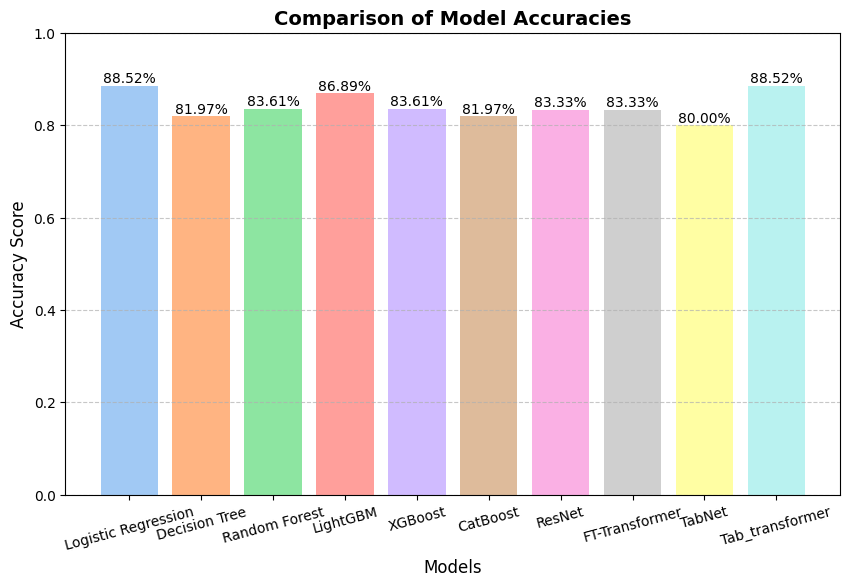

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'ResNet', 'FT-Transformer', 'TabNet', 'Tab_transformer']
accuracies = [log_acc, acc_dt, rf_acc, acc_lgb, acc_xgb, acc_cat, resnet_score, ftt_score, tabnet_score, tab_transformer_score]

colors = sns.color_palette("pastel", len(models))

plt.figure(figsize=(10, 6))

# 바 차트 그리기
bars = plt.bar(models, accuracies, color=colors,  linewidth=1.2)

plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{acc:.2%}",
             ha='center', va='bottom', fontsize=10)


plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.title("Comparison of Model Accuracies", fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()